# ** Predicting Housing Prices **
## Using Linear Regression, Lasso, Ridge, and ElasticNet
> Cleaning the Data
    > * Look for missing data
    > * Look for outliers
    > * Normalize and transform data
    > * Convert categorical variables
    > * Correcting Skewness with a Box Cox Transform
    
> Analysis
    > * Linear Regression
    > * Lasso
    > * Ridge
    > * ElasticNet
> Final Prediction and Submission

Note: Some of the structure for data cleaning and the stacking strategy were taken and modified from this user on kaggle: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard. 
Kudos to this guy.
I have made sure to understand what each line and each parameter does for the bits of code I took.

In [1214]:
import pandas as pd
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import numpy as np

train = pd.read_csv('/Users/neil/Desktop/train.csv', encoding="latin1")
test = pd.read_csv('/Users/neil/Desktop/test.csv', encoding="latin1")

In [1215]:
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


After importing our training and testing datasets, we take a look at train. He have 81 variables including out target variable SalePrice, and an Id variable. 

# Missing Data

Let's look for and fill in data that's missing.

In [1216]:
#Check for missing data in training data
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
train_missing_percentage = pd.DataFrame({'Percent Missing' :train_na})
train_missing_percentage.head(20)


,Percent Missing
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


It looks like there are a significant number of variables that are missing many observations. We'll take a look at each one individually to see why the values aren't there, or why Python thinks the values aren't there.

In [1217]:
#Check for missing values in testing data
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)[:30]
test_missing_percentage = pd.DataFrame({'Percent Missing' :test_na})
test_missing_percentage.head(20)


,Percent Missing
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
FireplaceQu,50.034270
LotFrontage,15.558602
GarageYrBlt,5.346127
GarageCond,5.346127
GarageQual,5.346127
GarageFinish,5.346127


Text(0.5,1,'Percent Missing Data by Feature')

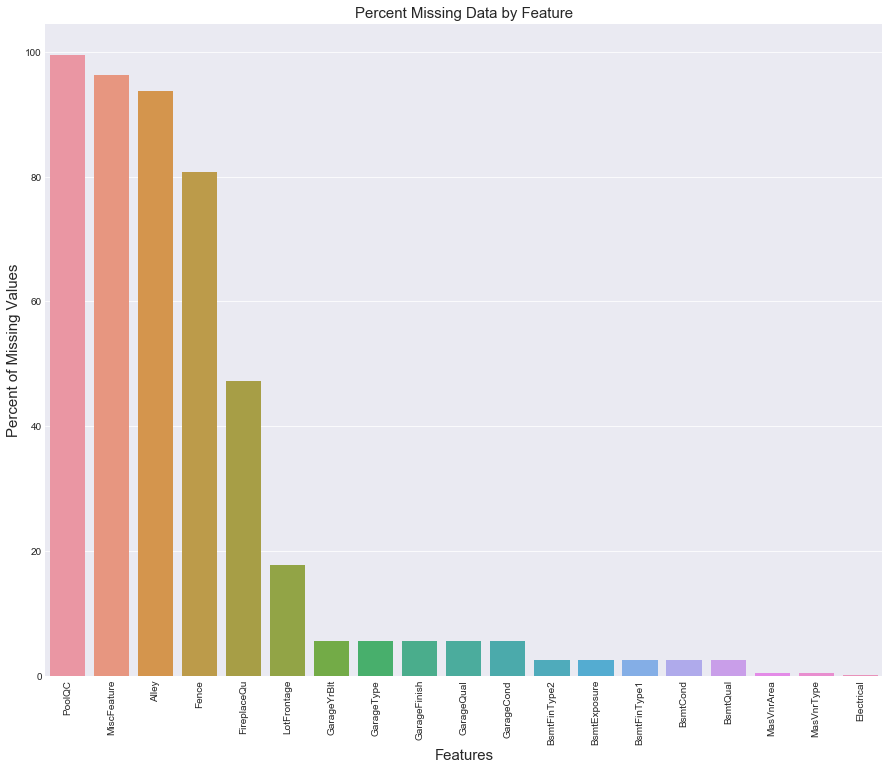

In [1218]:
#Graph percentage of missing data by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percent Missing Data by Feature', fontsize=15)


This graph tells us how much of each feature is missing. We'll haave to focus on the six left features, since a signifacnt portion of each of those is missing. The rest seem easily manageable, since so few are missing. 

We will examine each feature with missing data to determine what values are missing.

In [1219]:
train_missing = train[train.isnull().any(axis=1)]
train_missing[:10]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [1220]:
#Taking a look at the percentages of missing values
train_missing_percentage.head(20)


,Percent Missing
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


The folliwng variables with missing values are defined in the data description
> * PoolQC: NA	means No Pool
> * MiscFeature: NA	means None
> * Alley: NA 	means No alley access
> * Fence: NA	means No Fence
> * FireplaceQu: NA	means No Fireplace
> * LotFrontage: Linear feet of street connected to property
> * GarageYrBlt: Year garage was built
> * GarageCond: NA	means No Garage
> * GarageQual: NA	means No Garage
> * GarageFinish: NA	means No Garage
> * GarageType: NA	means No Garage
> * BsmtCond: NA means	No Basement
> * BsmtExposure: NA means	No Basement
    > * BsmtQual: NA means	No Basement
> * BsmtFinType1: NA means	No Basement
> * BsmtFinType2: NA means	No Basement
> * MasVnrType: None means	None
> * MasVnrArea: Masonry veneer area in square feet
> * MSZoning: Identifies the general zoning classification of the sale.
> * BsmtFullBath: Basement full bathrooms
> * Electrical: 

Pandas is likely interpreting those features using 'NA' to represent a lack of garage, pool, basement, etc. as having missing values. We will correct this misinterpretation by replacing these 'NA' values with 'None'. 
For the other features (LotFrontage, GarageYrBlt, MasVnrArea, MSZoning, BsmtFullBath, and Electrical), we will check how many values are missing, to see if we can easily drop them or replace them with the median values of their features.


In [1221]:
#Replacing 'NA' values for string features with 'None'
for x in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu','GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtCond', 
            'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
    train[x] = train[x].fillna('None')
for x in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu','GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtCond', 
            'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
    test[x] = test[x].fillna('None')

In [1222]:
#Counting the number of missing values for 'LotFrontage'
train['LotFrontage'].isna().sum()

259

259 is too significant an amount of observations to drop, so we will replace them with the median values in their neighborhood, since it is likely that houses in the same neighborhood will have the same lot frontage.

In [1223]:
#Group by neightborhood, and fill in missing LotFrontage with the median neighborhood value
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

GarageYrBlt likely has missing values because there is no garage in that house. So, we will replace the missing vlaues with '0'. 

In [1224]:
#Replacing missing values with zero
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

In [1225]:
#Counting the number of missing values for 'MasVnrArea'
train['MasVnrArea'].isna().sum()

8

These are likely houses in which there is no masonry veneer, so the area of it should be zero.

In [1226]:
#Replacing missing values with zero
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [1227]:
#Counting the number of missing values for 'MSZoning'
test['MSZoning'].isna().sum()

4

MSZoning only has 4 missing values, so we will replace the missing values with the most common value: 'RL' (Residential low density)

In [1228]:
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])

In [1229]:
#Counting the number of missing values for 'BsmtFullBath'
train['BsmtFullBath'].isna().sum()

0

BsmtFullBath only has 4 missing values, and these are likely because the house has no basement. So, we will replace the missing values with zero.

In [1230]:
#Replacing missing values with zero
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)
train['BsmtFullBath'] = train['BsmtFullBath'].fillna(0)

In [1231]:
#Counting the number of missing values for 'Electrical'
train['Electrical'].isna().sum()

1

'Electrical' has only one missing value, so we will fill it with the most common value.

In [1232]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

Finally, we will see if we have captured and tamed all of the missing values in our data.


In [1233]:
train_missing = train[train.isnull().any(axis=1)]
test_missing = test[test.isnull().any(axis=1)]

In [1234]:
train_missing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1235]:
test_missing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,72.0,10632,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,1,2010,COD,Normal
455,1916,30,RL,109.0,21780,Grvl,None,Reg,Lvl,NaN,...,0,0,None,None,None,0,3,2009,ConLD,Normal
485,1946,20,RL,63.0,31220,Pave,None,IR1,Bnk,NaN,...,0,0,None,None,Shed,750,5,2008,WD,Normal
660,2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,...,0,0,None,MnPrv,None,0,4,2008,ConLD,Abnorml
691,2152,30,RL,85.0,19550,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,1,2008,WD,Normal


It looks like we overlooked a few missing values. Let's correct this.

In [1236]:
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)
test_missing_data = pd.DataFrame({'Missing Ratio' :test_na})
test_missing_data[:20]

,Missing Ratio
Functional,0.13708
BsmtHalfBath,0.13708
Utilities,0.13708
SaleType,0.06854
GarageArea,0.06854
GarageCars,0.06854
KitchenQual,0.06854
TotalBsmtSF,0.06854
BsmtUnfSF,0.06854
BsmtFinSF2,0.06854


Here's what the data description has to say about these 13 variables:
> * Functional: Home functionality (Assume typical unless deductions are warranted)
       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
> * BsmtHalfBath: Basement half bathrooms (Should be zero if there is no basement)
> * Utilities: 
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only
> * SaleType: (Only one missing value; we fix this with the most common value)
> * GarageArea: (Should be zero if there is no garage)
> * GarageCars: (Should be zero if there is no garage)
> * KitchenQual: (Only one missing value; we fix this with the most common value)
> * TotalBsmtSF:(Zero for no basement)
> * BsmtUnfSF: (Zero for no basement)
> * BsmtFinSF2: (Zero for no basement)
> * BsmtFinSF1: (Zero for no basement)
> * Exterior2nd: (Only one missing value; we fix this with the most common value)
> * Exterior1st: (Only one missing value; we fix this with the most common value)


So, we can replace 'Functional' missing values with 'Typ' since the data description directs us to assume all values are typical unless deductions are warranted. Additionally, we can replace 'BsmtHalfBath' with zero if there is no basement, and 'GarageArea' with zero if there is no garage. We will look at 'Utilities', 'SaleType', 'KitchenQual', 'Exterior2nd', and 'Exterior1st' more closely.

In [1237]:
#Replacing missing values with zero

for x in ('BsmtHalfBath', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 
          'BsmtFinSF1' ):
    train[x] = train[x].fillna(0)
    test[x] = test[x].fillna(0)

#Replace 'Functional' missing values with 'Typ'
test['Functional'] = test['Functional'].fillna('Typ')
train['Functional'] = train['Functional'].fillna('Typ')

In [1238]:
#Look at 'Utilities' 
#Counting the number of missing values for 'Utilities'
test['Utilities'].isna().sum()

2

In [1239]:
test['Utilities'].value_counts()

AllPub    1457
Name: Utilities, dtype: int64

Since there is only one value for 'Utilities' other than the 2 missing values, we can safely drop that column entirely, since it will ahve no bearing on our prediction.

In [1240]:
train = train.drop(['Utilities'], axis=1)
test = test.drop(['Utilities'], axis=1)

In [1241]:
#Look at 'KitchenQual' 
#Counting the number of missing values for 'KitchenQual'
test['KitchenQual'].isna().sum()

1

In [1242]:
#Look at 'Exterior2nd' 
#Counting the number of missing values for 'Exterior2nd'
test['Exterior2nd'].isna().sum()

1

In [1243]:
#Look at 'Exterior1st' 
#Counting the number of missing values for 'Exterior1st'
test['Exterior1st'].isna().sum()

1

Only one value is missing for each, so we will fill them with the most common value.

In [1244]:
for x in ('SaleType', 'KitchenQual', 'Exterior2nd', 'Exterior1st'):
    train[x] = train[x].fillna(train[x].mode()[0])
    test[x] = test[x].fillna(test[x].mode()[0])

Let's check one more time for missing values:

In [1245]:
train_missing = train[train.isnull().any(axis=1)]
test_missing = test[test.isnull().any(axis=1)]

test_missing[:20]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


Success.

# Outliers
When we define our models later in this notebook, we will standardize using scikit learn's RobustScaler() (which removes the median and scales the data according to the quantile range, which often works better than removing the mean and dividing by the standard deviation when outliers are involved) to make our models robust to outliers.

# Normalization
It is important to check our data's distribution, since linear regression models favor normal distributions.

(Note: the following code for the graphs and the log transformation were taken almost unmodified from a user on kaggle: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard. I have made sure I understand what each line does and waht each parameter is for ;) )

/Users/neil/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'SalePrice distribution')

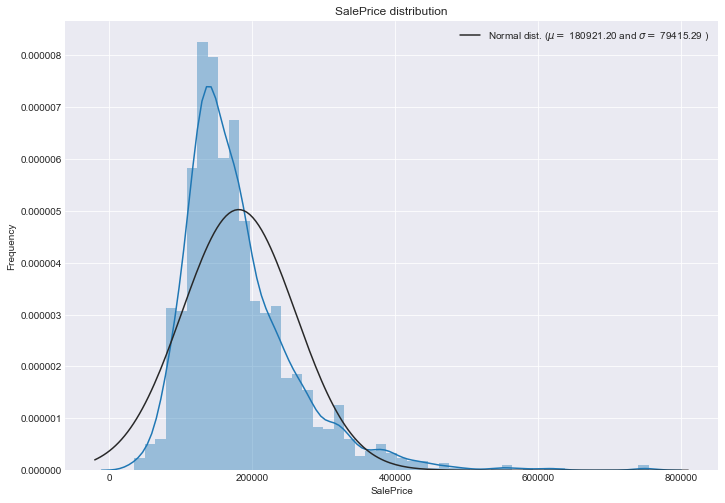

In [1246]:
from scipy.stats import norm
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

The sum of the blue rectangles represents the distribution of our data on SalePrice. The black line represents the ideal normal distribution, which would be optimal for out linear model. Since our data appear to be skewed away from the normal distribution, we will correct them by doing a log-transformation of 'SalePrice'.

/Users/neil/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'SalePrice distribution')

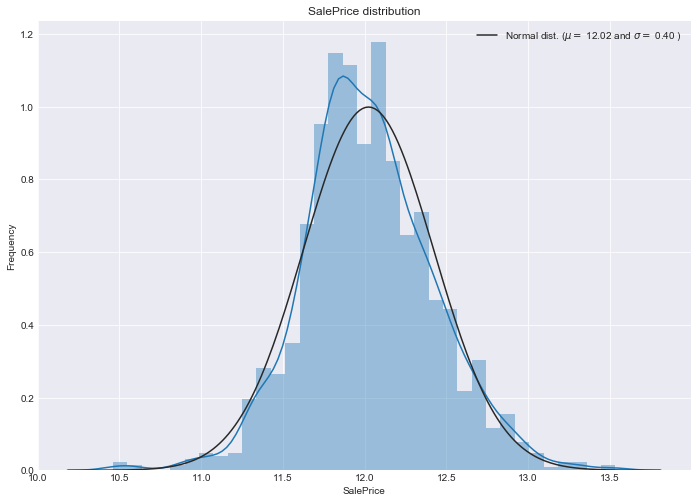

In [1247]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

It seems that the skew is now corrected, and closer to the ideal normal distribution.

# Categorical Conversion
It is important for us, when using linear regression-type models, to convert features that are listed as numerical but are really categorical variables. 

In [1248]:
ntrain = train.shape[0]
ntest = test.shape[0]
train_target = train.SalePrice.values
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
test_ids = test['Id']
all_data.drop(['Id'], axis=1, inplace=True)

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

for x in ('OverallCond', 'YrSold', 'MoSold'):
    all_data[x] = all_data[x].astype(str)
    
from sklearn.preprocessing import LabelEncoder
features = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for x in features:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[x].values)) 
    all_data[x] = lbl.transform(list(all_data[x].values))
       
print(all_data.shape)

(2919, 78)


# Skewness

Our linear regression models assume an unskewed (normal) dsitribution. To maximize the predictive power of our linear models, we need to diagnose and correct skewness in our data. 
Earlier, we corrected our target variable 'SalePrice'. Now, we will accordingly correct the numerical features of our data.

In [1249]:
#Separate the numerical features from our dataset
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features; only includes features that are skewed
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


To correct this batch of higly skewed features (skew above 0.7), we will use the Box Cox Transformation method:

In [1250]:
#We choose to correct skewness that is above an acceptable level; in this instance, above 0.7
skewness = skewness[abs(skewness) > 0.7]

#We implement the Box Cox Tranform
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

And as our final preparation for analysis, we finish converting all categorical variables to dummies.

In [1251]:
# Convert categorical to dummies in preparation for modelling
all_data = pd.get_dummies(all_data)

print(all_data.shape)

(2919, 220)


In [1252]:
train = all_data[:ntrain]
test = all_data[ntrain:]

print(train.shape)
print(test.shape)

(1460, 220)
(1459, 220)


It appears that our testing and training datasets are the same size, so we may proceed with modelling. 

# Models

In [1253]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.linear_model import ElasticNet, Lasso, Ridge

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(train, train_target, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(1460, 220)
(1459, 220)


We import necessary tools for the various models that we would like to run. We do a train-test-split to improve the predictive power of our models.

In [1254]:
# This is Tyler's function for plotting a learning curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

This block defines a function that will allow us to plot learning curves, which compare how our model does in the train test split. In other words, this plot will show us any problems with variance, bias, overfitting and under fitting.

In [1255]:
#Defines the number of folds for cross validation, shuffles the data before splitting
#Takes the root of the mean-squared-error given a model (i.e. Lasso, ElasticNet, Gradient Descent, etc.)
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=98).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, train_target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

This function is used to test our models for the lowest possible root mean squared error. We use cross validation with 5 folds here to find the hyper parameters that minimize the root mean squared error for any given model. 

## Linear Regression


In [1256]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

LRM = SGDRegressor(tol=.0001, eta0=.01)
LRM.fit(X_train, y_train)
train_predictions = LRM.predict(X_train)
test_predictions = LRM.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 2.9363975473897233e+21
Test MSE: 2.99036373877312e+21


<module 'matplotlib.pyplot' from '/Users/neil/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

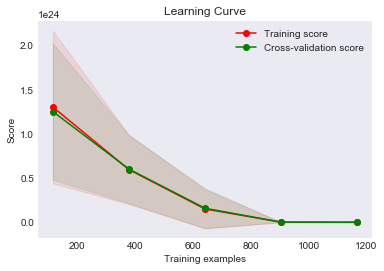

In [1257]:
plot_learning_curve(LRM, "Learning Curve", train, train_target, cv=5)

Our training score and our cross validation score for our Linear Regression model seem to be exactly the same for all values of training examples. This is likely to mean that the linear regression model is overfitting the data. Notice the confidence intervals for both the training score and the cross validation score are enormous.
Our root mean sqaured error here is not very good compared to other users on Kaggle. 
We can do better.

## Lasso


In [1258]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1245 (0.0162)



<module 'matplotlib.pyplot' from '/Users/neil/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

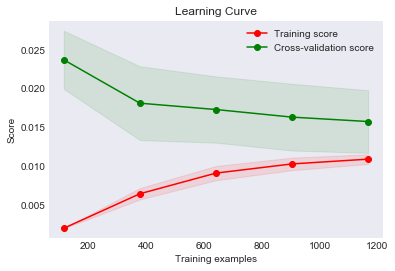

In [1259]:
plot_learning_curve(lasso, "Learning Curve", train, train_target, cv=5)

This Lasso model punishes large coefficients by adding the sum of the absolute values of the coefficients to the cost function. Since linear regression's goal is to minimize the cost function, the model forces the coefficients to be as small as possible. And as we see, the RMSE is significantly smaller than our linear regression model's estimation. The learning curves also look much better; perhaps there is a small variance problem, but not too significant.

## Ridge

In [1260]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha = 0.0005, random_state = 43))
score = rmsle_cv(ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Ridge score: 0.1380 (0.0172)



<module 'matplotlib.pyplot' from '/Users/neil/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

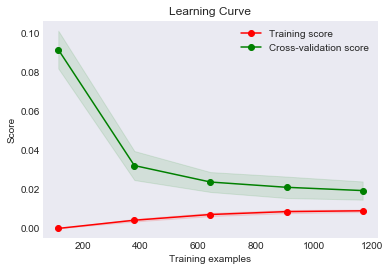

In [1261]:
plot_learning_curve(ridge, "Learning Curve", train, train_target, cv=5)

Similar to Lasso, Ridge punishes large coefficients by adding the square of the coefficients to the cost function. We see that this estimate has a slightly higher RMSE, but the training score and cross validation score seem to converge more quickly. 

## ElasticNet

In [1262]:
enet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = 0.9, random_state = 3))
score = rmsle_cv(enet)
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ElasticNet score: 0.1245 (0.0163)



<module 'matplotlib.pyplot' from '/Users/neil/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

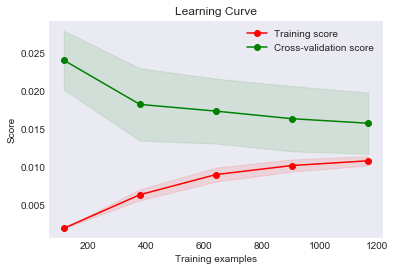

In [1263]:
plot_learning_curve(enet, "Learning Curve", train, train_target, cv=5)

ElasticNet combines both Lasso and Ridge models and weights them, in our case a little more toward Lasso, since it had a better initial score than Ridge. This estimate is identical to Lasso, with a slightly higher standard deviation.. 

We will use ElasticNet, a somewhat more robust model than Lasso or Ridge or Linear Regression, to make our final predictions, since it produced the best RMSE.

In [1264]:
enet.fit(X_train, y_train)
test_predictions = enet.predict(test)
test_predictions = np.exp(test_predictions)
submission = pd.DataFrame({"Id": test_ids, "SalePrice": test_predictions})

In [1265]:
submission.to_csv('submission.csv', index=False)

In [1266]:
submission.head()

,Id,SalePrice
0,1461,120655.569583
1,1462,150767.199416
2,1463,181598.630739
3,1464,191030.785619
4,1465,204308.063915
